In [1]:
import json
import os
from flask import Flask, render_template, request
from flask_cors import CORS
# from helpers.similarity import get_title_sim, cossim_scores
from helpers import preprocessing, similarity
import pandas as pd
from collections import defaultdict

In [2]:

with open("init.json", 'r') as file:
    data = json.load(file)
    kdramas_df = pd.DataFrame(data)


In [3]:
def cossim_search(query):
    inv_idx = preprocessing.build_inverted_index(kdramas_df['synopsis'])
    idf_dict = preprocessing.compute_idf(inv_idx, len(kdramas_df['synopsis']))
    doc_norms = preprocessing.compute_doc_norms(inv_idx, idf_dict, len(kdramas_df['synopsis']))
    scores = similarity.index_search(query, inv_idx, idf_dict, doc_norms)
    doc_ids = [doc_id for _, doc_id in scores]
    ranked_docs = kdramas_df.iloc[doc_ids]
    matches_filtered = ranked_docs if not ranked_docs.empty else kdramas_df
    matches_filtered_json = matches_filtered.to_json(orient='records')
    return [(score, kdramas_df.iloc[id]["name"]) for score, id in scores]

cossim_search("squid")

[]

In [20]:
from scipy.sparse.linalg import svds
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words = 'english', max_df = .8,
                            min_df = 1)
td_matrix = vectorizer.fit_transform(kdramas_df["synopsis"])
u, s, v_trans = svds(td_matrix, k=100)
print(u.shape)
print(s.shape)
print(v_trans.shape)

(1647, 100)
(100,)
(100, 10651)


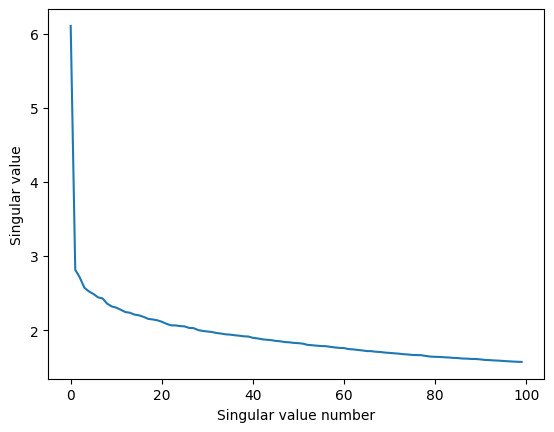

In [21]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(s[::-1])
plt.xlabel("Singular value number")
plt.ylabel("Singular value")
plt.show()

In [22]:
docs_compressed, s, words_compressed = svds(td_matrix, k=40)
words_compressed = words_compressed.transpose()

In [23]:
word_to_index = vectorizer.vocabulary_
index_to_word = {i:t for t,i in word_to_index.items()}
#row normalize
from sklearn.preprocessing import normalize
words_compressed_normed = normalize(words_compressed, axis = 1)
# cosine similarity
def closest_words(word_in, words_representation_in, k = 10):
    if word_in not in word_to_index: return "Not in vocab."
    sims = words_representation_in.dot(words_representation_in[word_to_index[word_in],:])
    asort = np.argsort(-sims)[:k+1]
    return [(index_to_word[i],sims[i]) for i in asort[1:]]
td_matrix_np = td_matrix.transpose()
td_matrix_np = normalize(td_matrix_np)


query = "guitar"
query_tfidf = vectorizer.transform([query]).toarray()
print("Non-zero entries in query_tfidf:", np.count_nonzero(query_tfidf))

query_vec = normalize(np.dot(query_tfidf, words_compressed)).squeeze()

docs_compressed_normed = normalize(docs_compressed)
def closest_projects_to_query(query_vec_in, k = 5):
    sims = docs_compressed_normed.dot(query_vec_in)
    asort = np.argsort(-sims)[:k+1]
    return [(i, kdramas_df.iloc[i]["name"],sims[i]) for i in asort[1:]]

for i, proj, sim in closest_projects_to_query(query_vec):
    print("({}, {}, {:.4f})".format(i, proj, sim))


Non-zero entries in query_tfidf: 1
(1572, A Tale of Two Sisters, 0.7301)
(769, Twenty Years Old, 0.6340)
(16, Navillera, 0.6163)
(1280, Young Lady and Gentleman, 0.6123)
(1165, People You May Know, 0.6042)


In [ ]:
vectorizer = TfidfVectorizer(stop_words = 'english', max_df = .8,
                            min_df = 1)
td_matrix = vectorizer.fit_transform(kdramas_df["synopsis"])
docs_compressed, s, words_compressed = svds(td_matrix, k=40)
words_compressed = words_compressed.transpose()
td_matrix_np = td_matrix.transpose()
td_matrix_np = normalize(td_matrix_np)
query = "guitar word horse"
query_tfidf = vectorizer.transform([query]).toarray()
print("Non-zero entries in query_tfidf:", np.count_nonzero(query_tfidf))

query_vec = normalize(np.dot(query_tfidf, words_compressed)).squeeze()

docs_compressed_normed = normalize(docs_compressed)
sims = docs_compressed_normed.dot(query_vec)
asort = np.argsort(-sims)
print([(kdramas_df.iloc[i]["name"],sims[i]) for i in asort[1:]])

Non-zero entries in query_tfidf: 3


NameError: name 'k' is not defined